In [11]:
%run 'pymol_and_pdb_functions.py'
start_pymol()

In [12]:
import itertools

%run 'ks01_Functions_only.ipynb'
notebook_prefix = 'ks16'
image_counter = Counter()

In [13]:
aa3 = "ALA CYS ASP GLU PHE GLY HIS ILE LYS LEU MET ASN PRO GLN ARG SER THR VAL TRP TYR XXX".split()
ascii_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
ascii_upper = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

### Creating 24-mer using his3 prediction, transferring substrate and Mn from PDB 4LOM

### Analyzing structure

In [84]:
his3_aligned_to_4lom_assembly_file = os.path.join(structure_predictions_folder, 
                                                  'his3_24mer_assembly', 'his3_swiss_aligned_to_4lom_assembly.pdb')

structure = Bio.PDB.PDBParser().get_structure('his3_swiss_assembly', his3_aligned_to_4lom_assembly_file)
model = structure[0]

/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 37657.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 37675.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 37693.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 37711.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 37729.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructi

In [71]:
position_translation = pd.read_table(files_dump_folder + 'position_translation.csv')
position_translation.set_index('relative_position', inplace=True)

def get_absolute_position(segment_number, relative_position):
    return int(position_translation.iloc[relative_position]['S'+str(segment_number)])

In [78]:
import re
pattern_mutations = '(^\D\d+\D)(\D\d+\D$)'
pattern_positions = '^\D(\d+)\D+(\d+)\D$'

reciprocal_sign_epistasis = pd.read_table(files_dump_folder + 'RepSign.tab')
reciprocal_sign_epistasis['mutation1'] = reciprocal_sign_epistasis['fused_mutations'].apply(lambda s: re.match(pattern_mutations, s).groups()[0])
reciprocal_sign_epistasis['mutation2'] = reciprocal_sign_epistasis['fused_mutations'].apply(lambda s: re.match(pattern_mutations, s).groups()[1])
reciprocal_sign_epistasis['position1'] = reciprocal_sign_epistasis['fused_mutations'].apply(lambda s: int(re.match(pattern_positions, s).groups()[0]))
reciprocal_sign_epistasis['position2'] = reciprocal_sign_epistasis['fused_mutations'].apply(lambda s: int(re.match(pattern_positions, s).groups()[1]))
reciprocal_sign_epistasis['position1'] = reciprocal_sign_epistasis.apply(lambda df: get_absolute_position(df['segment'], df['position1']-1), axis=1)
reciprocal_sign_epistasis['position2'] = reciprocal_sign_epistasis.apply(lambda df: get_absolute_position(df['segment'], df['position2']-1), axis=1)
reciprocal_sign_epistasis_positions = set.union(set(reciprocal_sign_epistasis['position1'].values), set(reciprocal_sign_epistasis['position1'].values))
reciprocal_sign_epistasis_positions = sorted([int(s) for s in reciprocal_sign_epistasis_positions])
print len(reciprocal_sign_epistasis_positions), 'positions under reciprocal sign epistasis'

59 positions under reciprocal sign epistasis


In [80]:
reciprocal_sign_epistasis.to_csv('/Users/karen/Downloads/reciprocal_sign_epistasis.csv', index=False)

In [18]:
def get_distance_between_atoms(atom1, atom2):
    diff_vector  = atom1.coord - atom2.coord
    return np.sqrt(np.sum(diff_vector * diff_vector))


def get_distance_between_residues(residue_one, residue_two, mode='min'):
    assert mode in ['CA', 'min']
    if mode == 'CA':
        diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
        return np.sqrt(np.sum(diff_vector * diff_vector))
    if mode == 'min':
        distances = []
        for atom1 in residue_one.get_atom():
            for atom2 in residue_two.get_atom():
                distances.append(get_distance_between_atoms(atom1, atom2))
        return min(distances)

    
def get_distance_to_other_residues(residue, other_residues, mode='min'):
    distances = np.zeros(len(other_residues))
    for index, other_residue in enumerate(other_residues):
        distances[index] = get_distance_between_residues(residue, other_residue, mode=mode)
    return distances

#### Sign epistasis

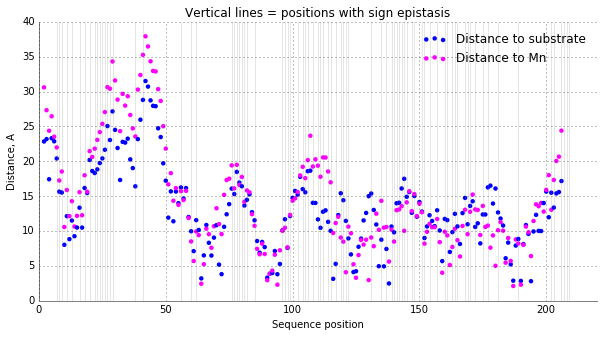

In [19]:
title = 'Sign epistasis vs distance to substrate and Mn'

substrate_color = 'blue'
mn_color = 'magenta'

sign_epistasis_dist_to_substrate = []
no_sign_epistasis_dist_to_substrate = []
sign_epistasis_dist_to_mn = []
no_sign_epistasis_dist_to_mn = []

plot_better()
residues = list(list(model.get_chains())[0].get_residues())
for index, residue in enumerate(strip_non_aa_residues(residues)):
    
    distance_to_substrate = min(get_distance_to_other_residues(residue, substrates))
    distance_to_mn = min(get_distance_to_other_residues(residue, mn))
    assert aa321[residue.get_resname()] == Scer_Uniprot[index+2 - 1]

    plt.scatter(index+2, distance_to_substrate, edgecolor='none', color=substrate_color)
    plt.scatter(index+2, distance_to_mn, edgecolor='none', color=mn_color)
    if index+2 in lucas_pBon001:
        sign_epistasis_dist_to_substrate.append(distance_to_substrate)
        sign_epistasis_dist_to_mn.append(distance_to_mn)
    else:
        no_sign_epistasis_dist_to_substrate.append(distance_to_substrate)
        no_sign_epistasis_dist_to_mn.append(distance_to_mn)

for position in lucas_pBon001:
    plt.axvline(position, ls='-', color='gray', alpha=0.2)

plt.title('Vertical lines = positions with sign epistasis')
plt.ylabel('Distance, A')
plt.xlabel('Sequence position')
plt.xlim(0,220)
plt.scatter(None, None, edgecolor='none', color='blue', label='Distance to substrate')
plt.scatter(None, None, edgecolor='none', color='magenta', label='Distance to Mn')
plt.legend(loc='upper right', frameon=False)
save_image(image_counter, title, figures_folder, notebook_prefix)

plt.savefig(figures_folder+'%s.pdf' %'_'.join(title.split()))

#### Reciprocal sign epistasis

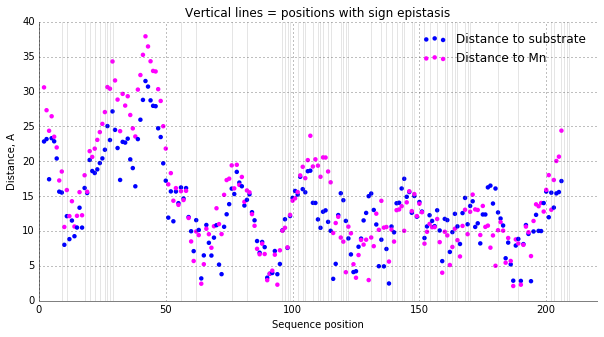

In [76]:
title = 'Reciprocal sign epistasis vs distance to substrate and Mn'

substrate_color = 'blue'
mn_color = 'magenta'

sign_epistasis_dist_to_substrate = []
no_sign_epistasis_dist_to_substrate = []
sign_epistasis_dist_to_mn = []
no_sign_epistasis_dist_to_mn = []

plot_better()
residues = list(list(model.get_chains())[0].get_residues())
for index, residue in enumerate(strip_non_aa_residues(residues)):
    
    distance_to_substrate = min(get_distance_to_other_residues(residue, substrates))
    distance_to_mn = min(get_distance_to_other_residues(residue, mn))
    assert aa321[residue.get_resname()] == Scer_Uniprot[index+2 - 1]

    plt.scatter(index+2, distance_to_substrate, edgecolor='none', color=substrate_color)
    plt.scatter(index+2, distance_to_mn, edgecolor='none', color=mn_color)
    if index+2 in reciprocal_sign_epistasis_positions:
        sign_epistasis_dist_to_substrate.append(distance_to_substrate)
        sign_epistasis_dist_to_mn.append(distance_to_mn)
    else:
            no_sign_epistasis_dist_to_substrate.append(distance_to_substrate)
        no_sign_epistasis_dist_to_mn.append(distance_to_mn)

for position in reciprocal_sign_epistasis_positions:
    plt.axvline(position, ls='-', color='gray', alpha=0.2)

plt.title('Vertical lines = positions with sign epistasis')
plt.ylabel('Distance, A')
plt.xlabel('Sequence position')
plt.xlim(0,220)
plt.scatter(None, None, edgecolor='none', color='blue', label='Distance to substrate')
plt.scatter(None, None, edgecolor='none', color='magenta', label='Distance to Mn')
plt.legend(loc='upper right', frameon=False)
save_image(image_counter, title, figures_folder, notebook_prefix)

plt.savefig(figures_folder+'%s.pdf' %'_'.join(title.split()))

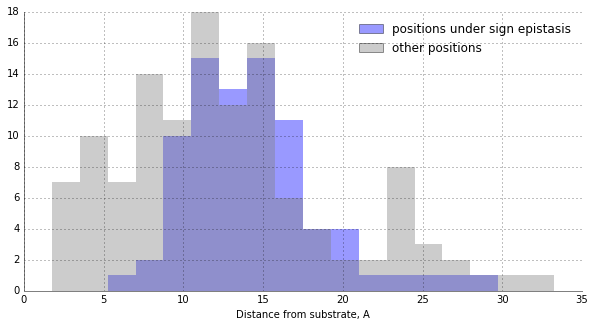

In [20]:
title = 'Reciprocal sign epistasis vs distance to substrate histogram'

plot_better()
plt.hist(sign_epistasis_dist_to_substrate, range=(0,35), bins=20, label='positions under sign epistasis', 
         edgecolor='none', alpha=0.4, color=substrate_color)
plt.hist(no_sign_epistasis_dist_to_substrate, edgecolor='none', range=(0,35), bins=20, alpha=0.4, color='gray', label='other positions')
plt.xlabel('Distance from substrate, A')
plt.legend(loc='upper right', frameon=False)

save_image(image_counter, title, figures_folder, notebook_prefix)
plt.savefig(figures_folder+'%s.pdf' %'_'.join(title.split()))

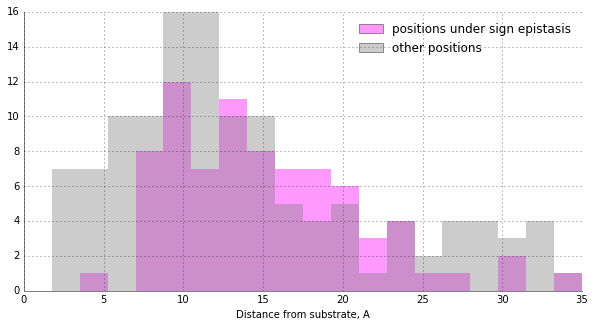

In [21]:
title = 'Sign epistasis vs distance to substrate histogram'

plot_better()
plt.hist(sign_epistasis_dist_to_mn, range=(0,35), bins=20, label='positions under sign epistasis', 
         edgecolor='none', alpha=0.4, color=mn_color)
plt.hist(no_sign_epistasis_dist_to_mn, edgecolor='none', range=(0,35), bins=20, alpha=0.4, color='gray', label='other positions')
plt.xlabel('Distance from nearest Mn atom, A')
plt.legend(loc='upper right', frameon=False)

save_image(image_counter, title, figures_folder, notebook_prefix)
plt.savefig(figures_folder+'%s.pdf' %'_'.join(title.split()))

In [31]:
from scipy import stats
print 'KS 2-sample test for distance substrate:\n', stats.ks_2samp(sign_epistasis_dist_to_substrate, no_sign_epistasis_dist_to_substrate)
print
print 'KS 2-sample test for distance Mn:\n',  stats.ks_2samp(sign_epistasis_dist_to_mn, no_sign_epistasis_dist_to_mn)

KS 2-sample test for distance substrate:
Ks_2sampResult(statistic=0.26650000000000001, pvalue=0.0014917283920581389)

KS 2-sample test for distance Mn:
Ks_2sampResult(statistic=0.2185, pvalue=0.015804600397267665)
